In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gc


# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp
import xobjects as xo


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst







tracked      = xPlus.Tracking_Interface.from_parquet('zfruits/tracking',partition_name='BUNCH',partition_ID='0224')
# tracked2     = xPlus.Tracking_Interface.from_parquet('zfruits/tracking',partition_name='BUNCH',partition_ID='0001')
calculations = xPlus.Tracking_Interface.from_parquet('zfruits/calculations',partition_name='BUNCH',partition_ID='0224')






# Adding Caclulations in sig coordinates
_self_sig = []
_self     = calculations
_df       = _self.calculations
_phase_space = ['x','px','y','py','zeta','pzeta']
for ii in ['min','max']:
    renaming = {f'{key}_{ii}':key for key in _phase_space}
    _n   = xPlus.W_phys2norm(**_df.rename(columns=renaming)[_phase_space],W_matrix=_self.W_matrix,particle_on_co=_self.particle_on_co,to_pd=True)
    _sig = xPlus.norm2sigma(**_n[['x_n','px_n','y_n','py_n','zeta_n','pzeta_n']],nemitt_x= _self.nemitt_x, nemitt_y= _self.nemitt_y, nemitt_zeta= _self.nemitt_zeta, particle_on_co=_self.particle_on_co,to_pd=True)

    renaming = {f'{key}_sig':f'{key}_sig_{ii}' for key in _phase_space}
    _self_sig.append(_sig.rename(columns=renaming))


calculations.calculations_sig = None
calculations.calculations_sig = pd.concat([_df[['start_at_turn','stop_at_turn','particle']]] + _self_sig,axis=1)




In [39]:
10*int(cst.LHC_F_REV)/2000 * 2.2 / 100

1.23695

---
# Computing particles lost on collimator
---

In [40]:
xt.ParticlesMonitor( _context         = self.context,
                                                        start_at_turn    = last_turn, 
                                                        stop_at_turn     = last_turn + chunk,
                                                        n_repetitions    = 1,
                                                        repetition_period= 1,
                                                    num_particles    = self.n_parts)

NameError: name 'self' is not defined

In [20]:

col_setting = 4 #sigma

real_x = tracked.coord[tracked.coord_sig.x_sig<col_setting].x.max()
real_y = tracked.coord[tracked.coord_sig.y_sig<col_setting].y.max()


# For regular tracking
#----------------------------------
df = tracked.df.copy()

collimator_lost     = df.groupby('particle').apply(lambda part: (np.cumsum(
                                                    # Condition: exceed col either in x or y
                                                    (part.x.abs()>real_x)|(part.y.abs()>real_y)
                                                    ).astype(bool)))
idx_collimator_lost = collimator_lost.index.get_level_values(1)

df.insert(0,'collimator_lost',False)
df.loc[idx_collimator_lost,'collimator_lost'] = collimator_lost.values
tracked.df_collimator = None
tracked.df_collimator = df
#----------------------------------


# For calculations
#----------------------------------
df = calculations.calculations.copy()

collimator_lost     = df.groupby('particle').apply(lambda part: (np.cumsum(
                                                    # Condition: exceed col either in x or y
                                                    (part.x_min.abs()>real_x)|(part.x_max.abs()>real_x)|(part.y_min.abs()>real_y)|(part.y_max.abs()>real_y)
                                                    ).astype(bool)))
idx_collimator_lost = collimator_lost.index.get_level_values(1)

df.insert(0,'collimator_lost',False)
df.loc[idx_collimator_lost,'collimator_lost'] = collimator_lost.values
calculations.calculations_collimator = None
calculations.calculations_collimator = df
#----------------------------------

In [18]:
%matplotlib widget

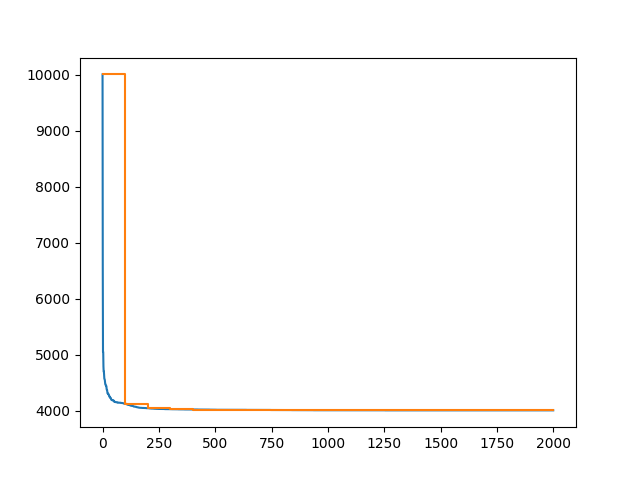

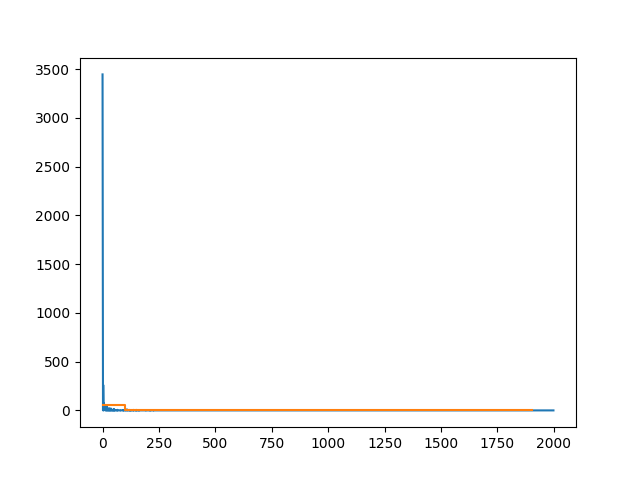

In [28]:
Intensity_trk = tracked.df_collimator[~tracked.df_collimator.collimator_lost].groupby('turn').count().particle
Intensity_clc = calculations.calculations_collimator[~calculations.calculations_collimator.collimator_lost].groupby('stop_at_turn').count().particle


plt.figure()
plt.plot(Intensity_trk.index,Intensity_trk.values)
# plt.plot(Intensity_clc.index,Intensity_clc.values)
plt.step(Intensity_clc.index,Intensity_clc.values,'-',where='post')
# plt.ylim([7e3,9e3])



plt.figure()
plt.plot(Intensity_trk.index[:-1],-np.diff(Intensity_trk.values))
# plt.plot(Intensity_clc.index[:-1],-np.diff(Intensity_clc.values))
plt.step(Intensity_clc.index[:-1],-np.diff(Intensity_clc.values)/np.diff(Intensity_clc.index),'-',where='post')
# plt.ylim([-5,10])


In [ ]:
Intensity = df[~df.collimator_lost].groupby('turn').count().particle

plt.figure()
plt.plot(Intensity.index,Intensity.values)
plt.ylim([7e3,9e3])



plt.figure()
plt.plot(Intensity.index[:-1],-np.diff(Intensity.values))
plt.ylim([-10,25])


In [ ]:
Intensity.values[-20:]

In [ ]:
np.argmin(traj.x_sig>col_setting)

In [ ]:
collimator_lost = np.zeros()

In [ ]:
_calc_n = []
for ii in ['min','max']:
 dummy = 
 _calc_n.append(xPlus.W_phys2norm(**calculations.calculations[[f'x_{key}',f'px_{key}',f'y_{key}',f'py_{key}',f'zeta_{key}',f'pzeta_{key}']],W_matrix=calculations.W_matrix,particle_on_co=calculations.particle_on_co,to_pd=True))

In [ ]:
calculations.calculations_sig

In [ ]:
calculations.calculations

In [ ]:
_sig.rename(columns=renaming)

In [ ]:
_n

In [ ]:
calculations.calculations

In [ ]:
calculations.calculations.rename(columns={'x_min':'x'})

In [ ]:
calculations.calculations

In [ ]:
~df.collimator_lost

In [ ]:
traj = df.groupby('particle').get_group(139)

# condition = np.invert(np.cumsum(traj.x_sig>col_setting).astype(bool))

plt.figure()
plt.plot(traj.turn,traj.x_sig)
plt.plot(traj[~traj.collimator_lost].turn,traj[~traj.collimator_lost].x_sig)

plt.ylim([-20,20])

In [ ]:
collimator_lost.index.get_level_values(1)

In [ ]:
col_setting = 15
traj = df.groupby('particle').get_group(139)

condition = np.invert(np.cumsum(traj.x_sig>col_setting).astype(bool))

plt.figure()
plt.plot(traj.turn,traj.x_sig)
plt.plot(traj[condition].turn,traj[condition].x_sig)

plt.ylim([-20,20])

In [ ]:
df.groupby('particle').apply(lambda part:) 

In [ ]:
df[df.state].groupby('turn').count()

In [ ]:
calculations.calculations
coord_n = W_phys2norm(**self.df[['x','px','y','py','zeta','pzeta']],W_matrix=self.W_matrix,particle_on_co=self.particle_on_co,to_pd=True)

In [ ]:
worst_particles[1:20]

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index
# for part_ID in worst_particles[1:20]:#np.arange(10,20):
for part_ID in np.arange(10,20):
    df = tracked.df_sig.groupby('particle').get_group(part_ID)
    calc = calculations.calculations_sig.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x_sig,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_sig_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_sig_max) + [np.nan],'-',where='post',color='C1')
    # plt.axhline(0.005,color='k')
    # plt.axhline(-0.005,color='k')
    # else:
    #     continue
    # plt.ylim([-0.007,0.007])

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index
for part_ID in worst_particles[1:20]:#np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = calculations.calculations.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

# worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=True).index
for part_ID in np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = calculations.calculations.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

In [ ]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

# worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=True).index
for part_ID in np.arange(10,20):
    df = tracked.df_n.groupby('particle').get_group(part_ID)
    calc = calculations.calculations.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.x_n,df.px_n,'-')
    # plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    # plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    # plt.axhline(0.005,color='k')
    # plt.axhline(-0.005,color='k')
    # else:
    #     continue
    # plt.ylim([-0.007,0.007])
    plt.axis('equal')

In [ ]:
tracked.df[tracked.df['turn']>=901]

In [ ]:
import matplotlib.pyplot as plt
test = calculations._calculations
for part in [0,10,20]:
    plt.figure()
    plt.plot(tracked.df.groupby('particle').get_group(part).turn,tracked.df.groupby('particle').get_group(part).x,'-')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_min,color='k')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_max,color='k')
    plt.xlim(900,1000)